## DATI TRENTINO ENERGIA

In [449]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import matthews_corrcoef,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import geopandas as gpd
import json
from shapely.geometry import Point, shape

pd.set_option('display.max_rows', 250)

In [450]:
from pathlib  import Path
data_path = Path(r'C:\Users\Francesco\Desktop\UniTN\datascience\progetto\TrentinoData\data_trentino\raw\trentino-grid.geojson')

files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson'}

# Creo dizionari per i vari dataframe e geodataframe

In [452]:
gdfs = {}
dfs = {}

# carico i geodf e df

In [456]:
base_folder = data_path.parent
for name, filename in files.items():
    path = base_folder / filename
    if filename.endswith(('.geojson', '.json')):
        try:
            gdfs[name] = gpd.read_file(path)
        except Exception as e:
            print(f"Errore nel caricare {filename} come GeoDataFrame: {e}")
    elif filename.endswith('.csv'):
        try:
            dfs[name] = pd.read_csv(path)
        except Exception as e:
            print(f"Errore nel caricare {filename} come DataFrame: {e}")

# i dataset sull'energia non hanno titolo, metto i titoli manualmente
nm = ['SET-1', 'SET-2']
for name in nm:
    first_row = dfs[name].columns.tolist()
    # 2. Riassegna i veri nomi delle colonne
    dfs[name].columns = ['LINESET', 'date', 'energy']
    # 3. Inserisci la prima riga come vero record
    dfs[name].loc[-1] = first_row  # aggiunge come nuova riga
    dfs[name].index = dfs[name].index + 1  # shift degli indici
    dfs[name] = dfs[name].sort_index()  # riordina le righe
    dfs[name]['energy'] = pd.to_numeric(dfs[name]['energy'], errors='coerce')
del nm

Errore nel caricare administrative_regions_Trentino.json come GeoDataFrame: Failed to read GeoJSON data
Errore nel caricare meteotrentino-weather-station-data.json come GeoDataFrame: Failed to read GeoJSON data
Errore nel caricare social-pulse-trentino.geojson come GeoDataFrame: Failed to read GeoJSON data


In [457]:
# carico gdf twitter e weather che non sono andati prima e anche il file csv sui dati sulla qualita' dell'aria

# twitter
with open(base_folder / files['twitter'], encoding='utf-8') as f:
    tweets_json = json.load(f)

tweets = pd.DataFrame(tweets_json['features'])
tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
tweets.drop(columns=['geomPoint.geom'], inplace=True)
tweets = gpd.GeoDataFrame(tweets, geometry='geometry', crs='EPSG:4326')
gdfs['twitter'] = tweets

#weather
with open(base_folder / files['weather'], encoding='utf-8') as f:
    weather_json = json.load(f)

weather = pd.DataFrame(weather_json['features'])
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'], inplace=True)
weather = gpd.GeoDataFrame(weather, geometry='geometry', crs='EPSG:4326')
gdfs['weather'] = weather

# qualita' aria
file_path = Path(r"C:\Users\Francesco\Desktop\UniTN\datascience\progetto\TrentinoData\data_trentino\external\APPA_inquinamento_aria_Nov_Dec_2013.csv")
dfs['inq_air'] = pd.read_csv(file_path, encoding='latin1', sep=',')

# sostituisco il nome della colonna con cellId in modo da poter fare merge con il gdf grid
dfs['SET-lines'].rename(columns={'SQUAREID': 'cellId'}, inplace=True)

## Inizio un po' di EDA

In [459]:
print(dfs.keys())
print(gdfs.keys())

dict_keys(['precip', 'precip-avail', 'SET-1', 'SET-2', 'SET-lines', 'inq_air'])
dict_keys(['grid', 'twitter', 'weather'])


In [460]:
dfs['precip-avail']

,201311010000,TRUE
0,201311010010,True
1,201311010020,True
2,201311010030,True
3,201311010040,True
4,201311010050,True
...,...,...
8778,201312312310,False
8779,201312312320,False
8780,201312312330,False
8781,201312312340,False


In [461]:
gdfs['grid']

,cellId,geometry
0,38,"POLYGON ((10.915 45.682, 10.927 45.682, 10.927..."
1,39,"POLYGON ((10.927 45.682, 10.94 45.682, 10.94 4..."
2,40,"POLYGON ((10.94 45.682, 10.953 45.681, 10.953 ..."
3,154,"POLYGON ((10.902 45.691, 10.915 45.691, 10.915..."
4,155,"POLYGON ((10.915 45.691, 10.928 45.691, 10.927..."
...,...,...
6570,11336,"POLYGON ((11.805 46.528, 11.818 46.527, 11.817..."
6571,11337,"POLYGON ((11.818 46.527, 11.831 46.527, 11.83 ..."
6572,11452,"POLYGON ((11.792 46.537, 11.805 46.537, 11.805..."
6573,11453,"POLYGON ((11.805 46.537, 11.818 46.536, 11.818..."


In [462]:
dfs['SET-1']

,LINESET,date,energy
0,DG1000420,2013-11-01 00:00,37.439999
1,DG1000420,2013-11-01 00:10,37.439999
2,DG1000420,2013-11-01 00:20,36.000000
3,DG1000420,2013-11-01 00:30,35.279999
4,DG1000420,2013-11-01 00:40,35.279999
...,...,...,...
794513,DG1056626,2013-11-30 23:10,46.549999
794514,DG1056626,2013-11-30 23:20,44.650002
794515,DG1056626,2013-11-30 23:30,44.599998
794516,DG1056626,2013-11-30 23:40,43.700001


In [463]:
prova = [dfs['SET-lines'][dfs['SET-lines']['cellId'] == 5317]]

Ora creo il mio dataframe dei dati energetici unendo i dati di novembre e dicembre, convertendo le date in numeri, piu' utili poi per allenare un modello di ML

In [466]:
# Creo i df che mi servono
sett_df = dfs['SET-1']
dec_df = dfs['SET-2']
lines_df = dfs['SET-lines']

# Creo il df unito per i due mesi
energy_df = pd.concat([sett_df, dec_df], ignore_index=True).fillna(0)

# Imposto le date come numeri
energy_df['month'] = pd.to_datetime(energy_df['date']).dt.month
energy_df['day'] = pd.to_datetime(energy_df['date']).dt.day
energy_df['hour'] = pd.to_datetime(energy_df['date']).dt.hour + \
                    pd.to_datetime(energy_df['date']).dt.minute/60
energy_df['week-day'] = pd.to_datetime(energy_df['date']).dt.day_of_week
del energy_df['date']
energy_df = energy_df[['LINESET', 'month', 'day', 'hour', 'week-day', 'energy']]

In [467]:
energy_df

,LINESET,month,day,hour,week-day,energy
0,DG1000420,11,1,0.000000,4,37.439999
1,DG1000420,11,1,0.166667,4,37.439999
2,DG1000420,11,1,0.333333,4,36.000000
3,DG1000420,11,1,0.500000,4,35.279999
4,DG1000420,11,1,0.666667,4,35.279999
...,...,...,...,...,...,...
1615889,DG1056626,12,31,23.166667,1,79.574997
1615890,DG1056626,12,31,23.333333,1,78.625000
1615891,DG1056626,12,31,23.500000,1,77.025002
1615892,DG1056626,12,31,23.666667,1,76.125000


## Mappa ubicaizoni e linee elettriche

Ora vado sul df delle linee elettriche, e le unisco a quelle della griglia per poter fare una mappa del numero di ubicazioni e una delle linee elettriche

In [470]:
# unisco i geodataframes in base a cell id
grid_ubicazioni = gdfs['grid'].merge(
    dfs['SET-lines'],
    on='cellId',
    how='left'
)

# Riempio i NaN con 0 per le celle che non hanno ubicazioni
grid_ubicazioni['NR_UBICAZIONI'] = grid_ubicazioni['NR_UBICAZIONI'].fillna(0).astype(int)

Ora stampo la mappa delle ubicazioni, mettendo NaN le celle con 0 nr di ubicazioni cosi le celle diventano grigie e si distinguono
meglio dalle celle con ubicazioni, e stampo anche la mappa con le diverse linee elettriche

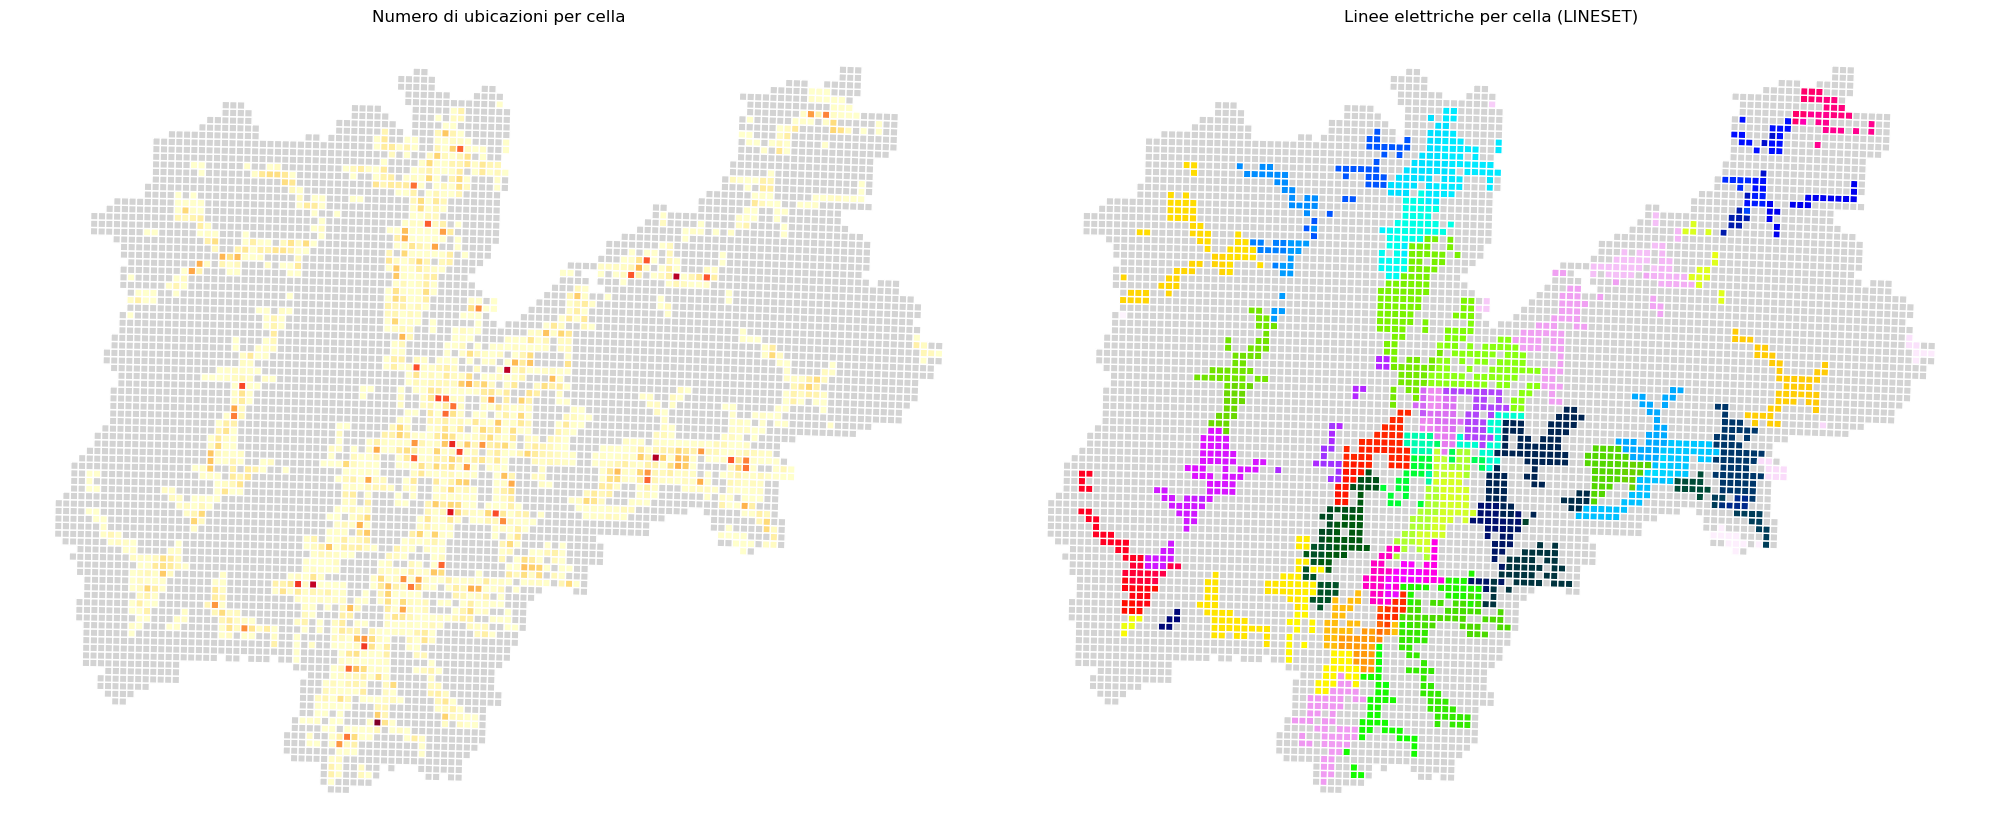

In [472]:
# Ora stampo la mappa, mettendo NaN le celle con 0 nr di ubicazioni cosi le celle diventano grigie
# e si distinguono meglio dalle celle con ubicazioni

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Mappa 1: Ubicazioni per cella
grid_plot = grid_ubicazioni.copy()
grid_plot['VALORI_PLOT'] = grid_ubicazioni['NR_UBICAZIONI'].replace(0, np.nan)
grid_plot.plot(
    ax=axs[0],
    column='VALORI_PLOT',
    cmap='YlOrRd',
    legend=False,
    edgecolor='white',
    missing_kwds={'color': 'lightgrey', 'label': '0 ubicazioni'}
)
axs[0].set_title("Numero di ubicazioni per cella")
axs[0].axis('off')

# Mappa 2: Linee elettriche
grid_ubicazioni.plot(
    ax=axs[1],
    column='LINESET',
    cmap='gist_ncar',
    legend=False,
    edgecolor='white',
    missing_kwds={'color': 'lightgrey', 'label': 'Nessuna linea'}
)
axs[1].set_title("Linee elettriche per cella (LINESET)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Si puo' vedere, come ci si aspetta, che le linee elettriche siano sovrapposte alle zone in cui c'è maggior presenza di ubicazioni.

## Unisco i dati dei due dataframes

Ora inizio a creare il dataframe che mi servira' per il training. Inizio creando un df che mi dice per ogni cella il numero di ubicazioni, la linea a cui e' collegata, il numero totale di ubicazioni collegate alla linea

In [476]:
lines_df

,cellId,LINESET,NR_UBICAZIONI
0,155,DG1031221,4
1,272,DG1031221,72
2,273,DG1031221,21
3,276,DG1003117,34
4,277,DG1003117,3
...,...,...,...
2570,10983,DG1013504,5
2571,10984,DG1013504,2
2572,11097,DG1013503,1
2573,11098,DG1013503,6


In [477]:
prova = lines_df[lines_df['LINESET'] == 'DG1031221']

In [478]:
prova

,cellId,LINESET,NR_UBICAZIONI
0,155,DG1031221,4
1,272,DG1031221,72
2,273,DG1031221,21
5,389,DG1031221,65
6,390,DG1031221,8
8,506,DG1031221,12
9,507,DG1031221,27
10,624,DG1031221,5
11,625,DG1031221,6
16,740,DG1031221,7


Pero' attenzione, perche ci sono delle celle attraverso le quali passano piu' linee
elettriche, infatti si vede che

In [480]:
print(lines_df['cellId'].nunique())
print(lines_df['cellId'].shape)

2020
(2575,)


In [481]:
# Conto quante linee elettriche passano per ogni cella
nr_lines_percell = lines_df.groupby('cellId')['LINESET'].size().reset_index()
nr_lines_percell = nr_lines_percell.rename(columns = {'LINESET' : 'NR_LINES'})

In [482]:
# Vedo in effetti che ci sono celle attraversate da piu linee
for ii in range (0, 11):
    _nr_lines = (nr_lines_percell['NR_LINES'] > ii).sum()
    print (f"Celle con piu di {ii} linee: {_nr_lines}")

Celle con piu di 0 linee: 2020
Celle con piu di 1 linee: 377
Celle con piu di 2 linee: 94
Celle con piu di 3 linee: 37
Celle con piu di 4 linee: 23
Celle con piu di 5 linee: 12
Celle con piu di 6 linee: 8
Celle con piu di 7 linee: 2
Celle con piu di 8 linee: 1
Celle con piu di 9 linee: 1
Celle con piu di 10 linee: 0


Devo dunque tenere conto che in lines_df nella colonna cellId avro valori che si ripetono e che corrispondono al fatto che quella cella e' collegata a piu' linee elettriche

In [485]:
# Creo df in cui ho il nr totale di ubicazioni per ogni cella che ne ha almeno una
ubic_4_cell = lines_df.groupby('cellId')['NR_UBICAZIONI'].sum().reset_index()
ubic_4_cell = ubic_4_cell.rename(columns = {'NR_UBICAZIONI' : 'UBIC_CELL'})

In [486]:
# df in cui ho il nr totale di ubicazioni per ogni linea
ubic_4_line = lines_df.groupby('LINESET')['NR_UBICAZIONI'].sum().reset_index()
ubic_4_line = ubic_4_line.rename(columns = {'NR_UBICAZIONI' : 'UBIC_LINE'})

In [493]:
# Ora unisco i df cosi da avere tutta l'informazione in un unico df
temp3 = pd.merge(lines_df, ubic_4_cell, on = 'cellId')
temp4 = pd.merge(temp3, ubic_4_line, on = 'LINESET')
del temp4['NR_UBICAZIONI']
# in questo modo ho un df in cui ho per ogni casella la linea a cui e collegata,
# nr di ubicazioni della cella e nr di ubicazioni totali della linea a cui 
# e collegata

In [494]:
# Ora unisco il df dell'energia con quello appena creato, cosi ho un df 
# con i dati per ogni cella e per ogni 10 minuti dei mesi di settembre e dicembre
energia_df = pd.merge(energy_df, temp4, on = 'LINESET')

energia_df = energia_df.merge(
    lines_df[['cellId', 'LINESET', 'NR_UBICAZIONI']],
    on=['cellId', 'LINESET'],
    how='left'
)

In [495]:
prova1 = energia_df[energia_df['cellId']==5317]

In [496]:
prova1

,LINESET,month,day,hour,week-day,energy,cellId,UBIC_CELL,UBIC_LINE,NR_UBICAZIONI
3454400,DG1002520,11,1,0.000000,4,29.174999,5317,562,400,57
3454406,DG1002520,11,1,0.166667,4,29.600000,5317,562,400,57
3454412,DG1002520,11,1,0.333333,4,29.950001,5317,562,400,57
3454418,DG1002520,11,1,0.500000,4,28.950001,5317,562,400,57
3454424,DG1002520,11,1,0.666667,4,28.900000,5317,562,400,57
...,...,...,...,...,...,...,...,...,...,...
17772171,DG1011928,12,31,23.166667,1,11.520000,5317,562,170,14
17772176,DG1011928,12,31,23.333333,1,11.520000,5317,562,170,14
17772181,DG1011928,12,31,23.500000,1,11.520000,5317,562,170,14
17772186,DG1011928,12,31,23.666667,1,11.520000,5317,562,170,14


In [497]:
# Infine calcolo per ogni cella e per ogni momento la frazione di potenza
# utilizzata dalla linea a cui e' collegata
energia_df['energy-frac'] = energia_df['energy']*energia_df['NR_UBICAZIONI']/  \
                            energia_df['UBIC_LINE']
del energia_df['energy']

In [498]:
# Riordino le celle e imposto l'ordine delle righe
energia_df = energia_df[['cellId', 'LINESET', 'month', 'day', 'hour', \
                         'week-day', 'UBIC_CELL', 'UBIC_LINE', 'energy-frac']]
energia_df = energia_df.sort_values(['cellId', 'month', 'day', 'hour']) \
            .reset_index(drop=True)
energia_df = energia_df.rename(columns = {'energy-frac' : 'energy'})

In [499]:
# Elimino i df creati temporaneamente che non mi servono piu'
del ubic_4_cell
del ubic_4_line
del temp3
del temp4

In [500]:
prova = energia_df[(energia_df['cellId'] == 5317) &(energia_df['hour']==0)]

In [501]:
prova

,cellId,LINESET,month,day,hour,week-day,UBIC_CELL,UBIC_LINE,energy
11249764,5317,DG1002520,11,1,0.0,4,562,400,4.157437
11249765,5317,DG1002522,11,1,0.0,4,562,320,6.757031
11249766,5317,DG1002525,11,1,0.0,4,562,464,13.247846
11249767,5317,DG1002528,11,1,0.0,4,562,744,0.856452
11249768,5317,DG1002529,11,1,0.0,4,562,893,6.429395
...,...,...,...,...,...,...,...,...,...
11336149,5317,DG1002531,12,31,0.0,1,562,637,2.862245
11336150,5317,DG1002533,12,31,0.0,1,562,285,1.171579
11336151,5317,DG1002536,12,31,0.0,1,562,349,1.136819
11336152,5317,DG1002538,12,31,0.0,1,562,3,2.000000


Allora finisco il df dei dati energetici sommando i valori di energia frazionaria
per le celle con piu linee elettriche, e tenendo solo le colonne che mi serviranno 
poi da features per il training

In [503]:
energia_df = energia_df.groupby(['cellId', 'month', 'day', 'hour', \
            'week-day', 'UBIC_CELL'])['energy'].sum().reset_index()

In [504]:
energia_df = energia_df.sort_values(['cellId', 'month', 'day', 'hour']).reset_index(drop=True)

Ora voglio creare una classe che mi permetta in maniera agevole di stmapare
la mappa dei consumi delle due fasce orarie giorno e sera

In [506]:
# Inizio creando un df che per ogni giorno e ogni fascia oraria
# mi da il consumo totale energetico
df = energia_df.copy()

# Crea la colonna 'fascia' per determinare la fascia oraria
def fascia_oraria(orario):
    if 8 <= orario < 19:
        return 'giorno'
    elif 19 <= orario < 24:
        return 'sera'
df['fascia'] = df['hour'].apply(fascia_oraria)

# Raggruppa per LINESET, giorno e fascia oraria, sommando l'energia
df_aggregato = df.groupby(['month', 'day', 'fascia', 'cellId'])\
                ['energy'].mean().reset_index()

In [507]:
df_aggregato['energy'].max()

241.0785175622873

In [508]:
class EnergyMap:

    """

    E' una classe che mi permette di generare agevolmente delle mappe dell'energia. In input prende data e fascia oraria con il formato
    mese: mm, giorno: gg, fascia oraria: "giorno" o "sera".

    metodi:
    plot() --> da in output la mappa del giorno e fascia oraria scelti dei consumi elettrici totali
    compare() --> da in output la mappa del giorno scelto della differenza di consumi elettrici tra giorno e sera

    """
    
    def __init__(self, mese, giorno, fascia):
        self.mese = mese
        self.giorno = giorno
        self.fascia = fascia

    def plot(self):
        # Filtro dei dati energetici
        day_filtered = df_aggregato[
            (df_aggregato['month'] == self.mese) &
            (df_aggregato['day'] == self.giorno) &
            (df_aggregato['fascia'] == self.fascia)
        ]


        # Merge con griglia geospaziale
        grid = gdfs['grid'].merge(day_filtered, on='cellId', how='left')

        # Determina il range per la scala colore
        _max = grid['energy'].max()
        _min = grid['energy'].min()
        max_abs = max(abs(_max), abs(_min))
        
        # greens = plt.cm.Greens_r(np.linspace(0.3, 1, 128))  
        # reds = plt.cm.Reds(np.linspace(0.3, 1, 128))       
        # combined = np.vstack((greens, reds))
        # cmap = ListedColormap(combined)
        # bounds = np.linspace(_min, _max, 256)
        # norm = BoundaryNorm(bounds, cmap.N)

        n_colors = 256
        greens = plt.cm.Greens_r(np.linspace(0.3, 1, n_colors // 2))
        reds = plt.cm.Reds(np.linspace(0.3, 1, n_colors // 2))
        colors = np.vstack((greens, reds))
        cmap = ListedColormap(colors)

        # Usa TwoSlopeNorm per dire al colormap dove si trova il "centro" (cioè lo 0)
        norm = TwoSlopeNorm(vmin=_min, vcenter=0, vmax=_max)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 10))
        grid.plot(
            column='energy',
            ax=ax,
            cmap=cmap,
            norm=norm,
            linewidth=0.1,
            edgecolor='gray',
            legend=True,
            vmin=_min,
            vmax=_max,
            missing_kwds={
                "color": "lightgrey",
                "label": "Nessun dato"
            }
        )
        ax.set_title(f"Consumo Energetico medio - {self.giorno:02d}/{self.mese:02d} - {self.fascia}", fontsize=14)
        ax.axis('off')
        plt.show()
    def compare(self):
        # Filtra i dati per il giorno selezionato, fascia 'giorno'
        giorno_df = df_aggregato[
            (df_aggregato['month'] == self.mese) &
            (df_aggregato['day'] == self.giorno) &
            (df_aggregato['fascia'] == 'giorno')
        ][['cellId', 'energy']].rename(columns={'energy': 'energy_giorno'})

        # Filtra i dati per la stessa data, fascia 'sera'
        sera_df = df_aggregato[
            (df_aggregato['month'] == self.mese) &
            (df_aggregato['day'] == self.giorno) &
            (df_aggregato['fascia'] == 'sera')
        ][['cellId', 'energy']].rename(columns={'energy': 'energy_sera'})

        # Merge per cellId per avere giorno e sera affiancati
        merged_df = pd.merge(giorno_df, sera_df, on='cellId', how='outer')\
                    .fillna(0)

        # Calcola la differenza: giorno - sera
        merged_df['diff'] = merged_df['energy_giorno'] - \
                            merged_df['energy_sera']

        # Unione con la griglia per visualizzare sulla mappa
        grid = gdfs['grid'].merge(merged_df[['cellId', 'diff']], \
                                  on='cellId', how='left')

        # Calcolo del range colore simmetrico
        _max = grid['diff'].max()
        _min = grid['diff'].min()
        max_abs = max(abs(_max), abs(_min))
        

        # # Crea la colormap rosso-verde centrata su zero
        # greens = plt.cm.Greens_r(np.linspace(0.3, 1, 128))
        # reds = plt.cm.Reds(np.linspace(0.3, 1, 128))
        # combined = np.vstack((greens, reds))
        # cmap = ListedColormap(combined)
        # bounds = np.linspace(_min, _max, 256)
        # norm = BoundaryNorm(bounds, cmap.N)

        n_colors = 256
        greens = plt.cm.Greens_r(np.linspace(0.3, 1, n_colors // 2))
        reds = plt.cm.Reds(np.linspace(0.3, 1, n_colors // 2))
        colors = np.vstack((greens, reds))
        cmap = ListedColormap(colors)

        # Usa TwoSlopeNorm per dire al colormap dove si trova il "centro" (cioè lo 0)
        norm = TwoSlopeNorm(vmin=_min, vcenter=0, vmax=_max)

        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 10))
        grid.plot(
            column='diff',
            ax=ax,
            cmap=cmap,
            norm=norm,
            linewidth=0.1,
            edgecolor='gray',
            legend=True,
            vmin=_min,
            vmax=_max,
            missing_kwds={
                "color": "lightgrey",
                "label": "Nessun dato"
            }
        )
        ax.set_title(f"Diff. energia media(giorno - sera) - {self.giorno:02d}/{self.mese:02d}", fontsize=14)
        ax.axis('off')
        plt.show()

In [509]:
EnergyMap?

Init signature: EnergyMap(mese, giorno, fascia)
Docstring:     
E' una classe che mi permette di generare agevolmente delle mappe dell'energia. In input prende data e fascia oraria con il formato
mese: mm, giorno: gg, fascia oraria: "giorno" o "sera".

metodi:
plot() --> da in output la mappa del giorno e fascia oraria scelti dei consumi elettrici totali
compare() --> da in output la mappa del giorno scelto della differenza di consumi elettrici tra giorno e sera
Type:           type
Subclasses:     

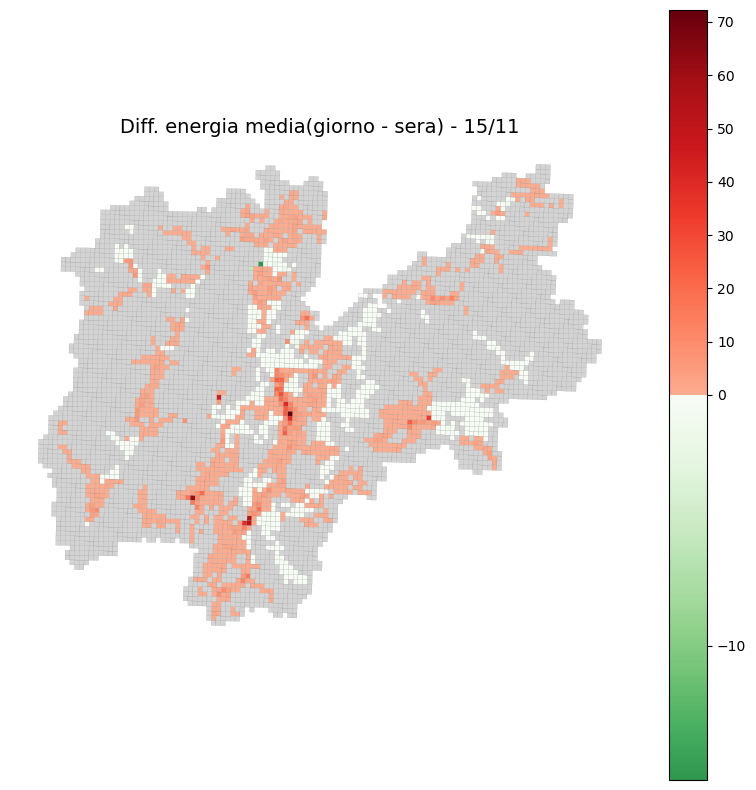

In [513]:
dayprova = [11, 15, 'giorno']
EnergyMap(*dayprova).compare()

## Dati meteo

Ora ci interessa aggiungere al nostro df i dati delle 39 stazioni meteo

In [578]:
# Creo il df che mi serve
weather_df = gdfs['weather']

In [587]:
weather_df

,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperatures.0000,...,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345,geometry
0,T0071,905,2013-11-01,1383260400,4.5,12.3,False,0.0,2.5,8.4,...,,0@157,,0.4@228,0.3@248,,0@201,0@199,,POINT (10.796 46.313)
1,T0032,1155,2013-11-01,1383260400,6.5,10.2,False,NaN,NaN,7.3,...,,,,,,,,,,POINT (11.254 45.94)
2,T0096,1205,2013-11-01,1383260400,6.5,11.8,False,NaN,NaN,8.2,...,,,,,,,,,,POINT (11.665 46.384)
3,T0074,720,2013-11-01,1383260400,6.2,13.6,False,0.0,4.8,10.2,...,0.3@196,0.4@236,,0.9@15,0.6@345,1@244,0.5@192,0@157,,POINT (10.918 46.352)
4,T0101,201,2013-11-01,1383260400,11.1,16.3,False,NaN,NaN,12.8,...,,,,,,,,,,POINT (11.08 46.156)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,T0431,1055,2013-12-31,1388444400,-5.5,0.5,False,NaN,NaN,-3.4,...,,,,,,,,,,POINT (11.336 46.263)
2191,T0428,525,2013-12-31,1388444400,-2.2,6.9,False,NaN,NaN,-0.4,...,,,,,,,,,,POINT (10.642 45.941)
2192,T0437,1465,2013-12-31,1388444400,-9.9,-2.4,False,0.1,2.5,-8.3,...,1@113,1.3@105,1.1@115,0.9@113,1@115,1.4@110,1.4@98,1.5@109,1.5@106,POINT (11.767 46.478)
2193,T0469,801,2013-12-31,1388444400,-4.1,2.7,False,0.1,1.4,-2.5,...,0.7@83,0.3@148,,0.8@35,0.5@349,0.7@340,0.4@353,0.8@353,0.7@15,POINT (11.63 46.057)


In [589]:
# Creiamo un gdf solo con il nome e la posizione delle stazioni
stations_df = weather_df.drop_duplicates(subset='station', keep='first')[['station', 'geometry']]

In [591]:
stations_df

,station,geometry
0,T0071,POINT (10.796 46.313)
1,T0032,POINT (11.254 45.94)
2,T0096,POINT (11.665 46.384)
3,T0074,POINT (10.918 46.352)
4,T0101,POINT (11.08 46.156)
5,T0118,POINT (11.218 46.171)
6,T0129,POINT (11.136 46.072)
7,T0236,POINT (11.119 46.391)
8,T0135,POINT (11.101 46.096)
9,T0139,POINT (11.302 46.107)


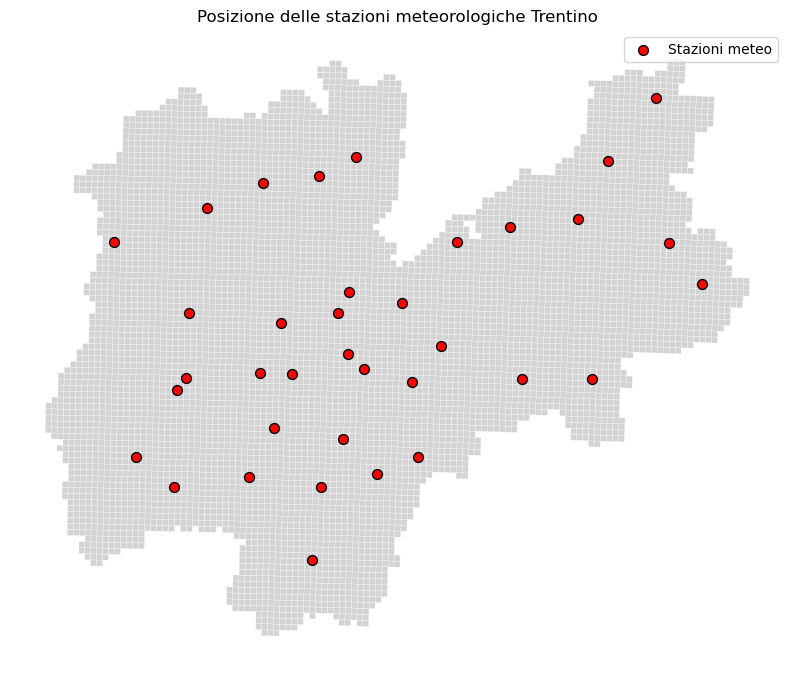

In [593]:
# Plotto la mappa del Trentino con le stazioni meteo
fig, ax = plt.subplots(figsize=(10, 10))

gdfs['grid'].plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.2)
stations_df.plot(ax=ax, color='red', markersize=50, edgecolor='black', label='Stazioni meteo')

ax.set_title("Posizione delle stazioni meteorologiche Trentino")
ax.axis('off')
ax.legend()
plt.show()

Ora voglio collegare ogni casella alla sua stazione piu' vicina. Per farlo usando esiste una funzione apposita di geopandas sjoin_nearest(), ma per usarla le servono coordinate spaziali in metri, mentre noi stiamo usando coordinate geografiche latitudine/longitudine. Dobbiamo quindi prima convertire le coordinate con to_crs(epsg=326320), con epsg=326320 che indica European Petroleum Survey Group, che e' il sistema di coordinate, e 326320 che indica la zona della terra che comprende nord italia, austria, svizzera, germania ecc..

In [596]:
grid_proj = gdfs['grid'].to_crs(epsg=32632)
stations_proj = stations_df.to_crs(epsg=32632)

gdf_con_stazioni = gpd.sjoin_nearest(
    grid_proj,
    stations_proj,
    how='left',
    distance_col='distance_to_station'
)

In [598]:
gdf_con_stazioni

,cellId,geometry,index_right,station,distance_to_station
0,38,"POLYGON ((6.49e+05 5.06e+06, 6.5e+05 5.06e+06,...",26,T0405,13807.002615
1,39,"POLYGON ((6.5e+05 5.06e+06, 6.51e+05 5.06e+06,...",26,T0405,13312.524960
2,40,"POLYGON ((6.51e+05 5.06e+06, 6.52e+05 5.06e+06...",26,T0405,12876.852116
3,154,"POLYGON ((6.48e+05 5.06e+06, 6.49e+05 5.06e+06...",26,T0405,13545.749178
4,155,"POLYGON ((6.49e+05 5.06e+06, 6.5e+05 5.06e+06,...",26,T0405,12964.463753
...,...,...,...,...,...
6570,11336,"POLYGON ((7.15e+05 5.16e+06, 7.16e+05 5.16e+06...",36,T0437,5328.901520
6571,11337,"POLYGON ((7.16e+05 5.16e+06, 7.17e+05 5.16e+06...",36,T0437,5901.287311
6572,11452,"POLYGON ((7.14e+05 5.16e+06, 7.15e+05 5.16e+06...",36,T0437,5843.046334
6573,11453,"POLYGON ((7.15e+05 5.16e+06, 7.16e+05 5.16e+06...",36,T0437,6210.409888


Ora posso stampare la mappa con le caselle colorate in base alla stazione 
meteo piu' vicina

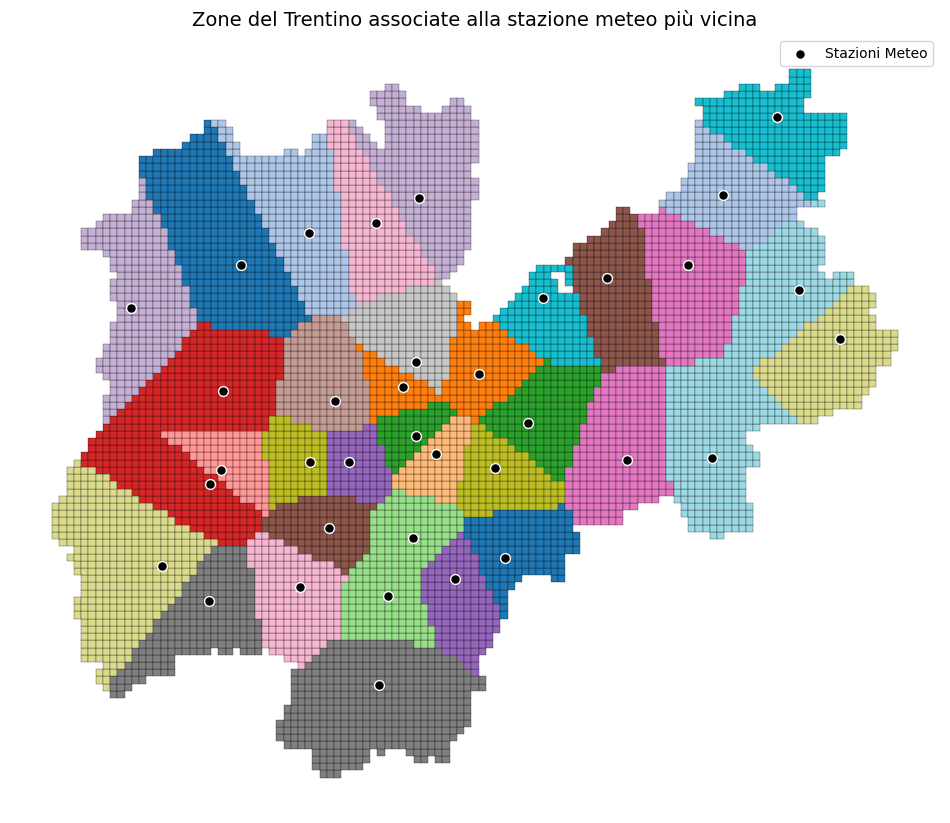

In [600]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot in base alla stazione collegata alla cella
gdf_con_stazioni.plot(
    ax=ax,
    column='station',
    categorical=True,
    legend=True,
    cmap='tab20',
    edgecolor='black',
    linewidth=0.2
)

# Plot delle stazioni
stations_proj.plot(
    ax=ax,
    color='black',
    markersize=50,
    edgecolor='white',
    label='Stazioni Meteo'
)

ax.set_title("Zone del Trentino associate alla stazione meteo più vicina", fontsize=14)
ax.axis('off')
ax.legend()
plt.show()

Ora creo un df che mi dica per ogni cella, ogni giorno e ogni fascia oraria,
il valore minimo, massimo e medio delle temperature

In [604]:
# Seleziono le colonne che iniziano con temperatures
temp_cols = [col for col in weather_df.columns if col.startswith('temperatures.')]

# Genero due liste in cui metto le colonne delle temperature giuste per le
# fasce orarie desideraate
giorno_cols = []
sera_cols = []

# Lo faccio con un ciclo
for col in temp_cols:
    time_str = col.split('.')[-1]
    hh = int(time_str[:2])
    mm = int(time_str[2:])
    total_minutes = hh * 60 + mm

    if 8 * 60 <= total_minutes < 19 * 60:
        giorno_cols.append(col)
    elif 19 * 60 <= total_minutes < 24 * 60:
        sera_cols.append(col)

# Calcolo la media delle temperature in orizzontale --> axis=1
giorno_df = pd.DataFrame()
giorno_df['station'] = weather_df['station']
giorno_df['date'] = weather_df['date']
giorno_df['fascia'] = 'giorno'
giorno_df['temp_min'] = weather_df[giorno_cols].min(axis=1)
giorno_df['temp_max'] = weather_df[giorno_cols].max(axis=1)
giorno_df['temp_mean'] = weather_df[giorno_cols].mean(axis=1)

sera_df = pd.DataFrame()
sera_df['station'] = weather_df['station']
sera_df['date'] = weather_df['date']
sera_df['fascia'] = 'sera'
sera_df['temp_min'] = weather_df[sera_cols].min(axis=1)
sera_df['temp_max'] = weather_df[sera_cols].max(axis=1)
sera_df['temp_mean'] = weather_df[sera_cols].mean(axis=1)

# Ora unisco le due fasce orarie
stazioni_fasce_df = pd.concat([giorno_df, sera_df], ignore_index=True)
stazioni_fasce_df = stazioni_fasce_df.fillna(0)

In [605]:
stazioni_fasce_df

,station,date,fascia,temp_min,temp_max,temp_mean
0,T0071,2013-11-01,giorno,4.6,12.3,9.627273
1,T0032,2013-11-01,giorno,7.0,10.2,8.688636
2,T0096,2013-11-01,giorno,6.6,11.8,9.645455
3,T0074,2013-11-01,giorno,6.3,13.6,11.088636
4,T0101,2013-11-01,giorno,11.7,16.3,14.961364
...,...,...,...,...,...,...
4385,T0431,2013-12-31,sera,-4.6,-2.4,-3.530000
4386,T0428,2013-12-31,sera,-2.2,0.4,-1.310000
4387,T0437,2013-12-31,sera,-9.0,-7.4,-8.268421
4388,T0469,2013-12-31,sera,-3.6,-2.2,-3.000000


In [608]:
# Unisco questo e l'altro df in modo da avere per ogni cella, giorno e fascia oraria i
# valori di temperature
weather_fasce_df = stazioni_fasce_df.merge(gdf_con_stazioni, on='station', how='left')
weather_fasce_df = weather_fasce_df[['cellId', 'date', 'fascia', 'temp_min', 'temp_max', 'temp_mean' ]]

weather_fasce_df = weather_fasce_df.sort_values(['cellId', 'date']).reset_index(drop=True)

In [609]:
# Sostituisco anche qui la data
weather_fasce_df['month'] = pd.to_datetime(weather_fasce_df['date']).dt.month
weather_fasce_df['day'] = pd.to_datetime(weather_fasce_df['date']).dt.day
weather_fasce_df['hour'] = pd.to_datetime(weather_fasce_df['date']).dt.hour + \
                    pd.to_datetime(weather_fasce_df['date']).dt.minute/60
weather_fasce_df['week-day'] = pd.to_datetime(weather_fasce_df['date']).dt.day_of_week
del weather_fasce_df['date']
del weather_fasce_df['hour']

In [612]:
weather_fasce_df

,cellId,fascia,temp_min,temp_max,temp_mean,month,day,week-day
0,38,giorno,9.3,18.9,15.384091,11,1,4
1,38,sera,11.9,12.9,12.315000,11,1,4
2,38,giorno,12.3,15.9,13.897727,11,2,5
3,38,sera,12.2,13.1,12.550000,11,2,5
4,38,giorno,12.2,19.2,15.213636,11,3,6
...,...,...,...,...,...,...,...,...
801841,11454,sera,-2.6,0.0,-1.485000,12,29,6
801842,11454,giorno,-7.3,-1.4,-4.270455,12,30,0
801843,11454,sera,-7.7,-6.1,-6.905000,12,30,0
801844,11454,giorno,-9.9,-2.4,-5.723256,12,31,1


Ora creo il df a partire da energia_df che mi dia l'energia media

In [615]:
energia_df

,cellId,month,day,hour,week-day,UBIC_CELL,energy,fascia
0,155,11,1,0.000000,4,4,0.101565,None
1,155,11,1,0.166667,4,4,0.086957,None
2,155,11,1,0.333333,4,4,0.093913,None
3,155,11,1,0.500000,4,4,0.089391,None
4,155,11,1,0.666667,4,4,0.088696,None
...,...,...,...,...,...,...,...,...
17423497,11099,12,31,23.166667,1,3,0.086851,sera
17423498,11099,12,31,23.333333,1,3,0.082788,sera
17423499,11099,12,31,23.500000,1,3,0.081941,sera
17423500,11099,12,31,23.666667,1,3,0.077709,sera


In [617]:
# Creo la colonna 'fascia' in base all'ora
def fascia_oraria(hour):
    if 8 <= hour < 19:
        return 'giorno'
    elif 19 <= hour < 24:
        return 'sera'
    else:
        return None  # Escludo le ore notturne (0-8)

energia_df['fascia'] = energia_df['hour'].apply(fascia_oraria)

# Rimuovo le righe con fascia = None, che sono quelle della fascia 0-8
energia_df_filt = energia_df.dropna(subset=['fascia'])

# Raggruppo e medio l’energia per cella, mese, giorno e fascia
energia_fasce_df = energia_df_filt.groupby(
    ['cellId', 'month', 'day', 'fascia', 'week-day', 'UBIC_CELL'],
    as_index=False
)['energy'].mean()

In [619]:
energia_fasce_df

,cellId,month,day,fascia,week-day,UBIC_CELL,energy
0,155,11,1,giorno,4,4,0.072206
1,155,11,1,sera,4,4,0.129090
2,155,11,2,giorno,5,4,0.128870
3,155,11,2,sera,5,4,0.131733
4,155,11,3,giorno,6,4,0.102435
...,...,...,...,...,...,...,...
242043,11099,12,29,sera,6,3,0.325564
242044,11099,12,30,giorno,0,3,0.324854
242045,11099,12,30,sera,0,3,0.336806
242046,11099,12,31,giorno,1,3,0.337902


In [621]:
df_finale = pd.merge(
    energia_fasce_df,
    weather_fasce_df,
    on=['cellId', 'month', 'day', 'fascia', 'week-day'],
    how='inner'
)

In [623]:
prova = df_finale.sort_values(by='energy')

In [625]:
prova

,cellId,month,day,fascia,week-day,UBIC_CELL,energy,temp_min,temp_max,temp_mean
128470,5537,11,3,giorno,6,34,-54.785556,10.4,14.8,12.350000
128466,5537,11,1,giorno,4,34,-46.226526,9.0,13.4,11.431818
196022,8212,11,3,giorno,6,278,-45.614368,5.8,11.2,8.947727
196018,8212,11,1,giorno,4,278,-42.974103,4.6,12.3,9.627273
128484,5537,11,10,giorno,6,34,-42.162282,3.7,8.2,5.836364
...,...,...,...,...,...,...,...,...,...,...
110746,5201,12,17,giorno,1,1288,228.283708,0.4,8.1,5.011364
110748,5201,12,18,giorno,2,1288,228.329358,0.5,6.0,3.636364
110752,5201,12,20,giorno,4,1288,228.489381,0.9,3.5,2.209091
110722,5201,12,5,giorno,3,1288,232.563937,2.6,10.7,6.929545


## Dati twitter

Ora creo un df dai dati twitter

In [629]:
twitter_gdf = gdfs['twitter'][['created', 'geometry']].copy()

In [631]:
twitter_gdf

,created,geometry
0,2013-11-01T00:04:16,POINT (11.13 46.07)
1,2013-11-01T00:01:14,POINT (10.83 46.23)
2,2013-11-01T00:43:03,POINT (11.46 46.29)
3,2013-11-01T00:38:37,POINT (11.04 45.89)
4,2013-11-01T00:45:40,POINT (11.12 46.2)
...,...,...
27936,2013-12-31T00:25:48,POINT (11.68 46.42)
27937,2013-12-29T13:12:46,POINT (11.6 46.31)
27938,2013-11-19T00:51:39,POINT (11.3 46.11)
27939,2013-11-23T09:49:36,POINT (11.3 46.11)


Quello che mi serve e' un df che per ogni mese, giorno e fascia oraria mi conta quanti tweets 
ci sono stati per ogni casella

In [633]:
# Imposto il formato data corretto
twitter_gdf['created'] = pd.to_datetime(twitter_gdf['created'])

In [634]:
gdfs['grid']

,cellId,geometry
0,38,"POLYGON ((10.915 45.682, 10.927 45.682, 10.927..."
1,39,"POLYGON ((10.927 45.682, 10.94 45.682, 10.94 4..."
2,40,"POLYGON ((10.94 45.682, 10.953 45.681, 10.953 ..."
3,154,"POLYGON ((10.902 45.691, 10.915 45.691, 10.915..."
4,155,"POLYGON ((10.915 45.691, 10.928 45.691, 10.927..."
...,...,...
6570,11336,"POLYGON ((11.805 46.528, 11.818 46.527, 11.817..."
6571,11337,"POLYGON ((11.818 46.527, 11.831 46.527, 11.83 ..."
6572,11452,"POLYGON ((11.792 46.537, 11.805 46.537, 11.805..."
6573,11453,"POLYGON ((11.805 46.537, 11.818 46.536, 11.818..."


In [635]:
# Vedo che le colonne geometry hanno due formati diversi, converto a quello che mi serve
grid_proj = gdfs['grid'].to_crs(epsg=32632)
tweets_proj = twitter_gdf.to_crs(epsg=32632)

tweets_with_cell = gpd.sjoin(
    tweets_proj,
    grid_proj[['cellId', 'geometry']],
    how='inner',
    predicate='intersects'
)

In [640]:
def fascia_oraria(dt):
    ora = dt.hour
    if 8 <= ora < 19:
        return 'giorno'
    elif 19 <= ora < 24:
        return 'sera'

tweets_with_cell['fascia'] = tweets_with_cell['created'].apply(fascia_oraria)
tweets_with_cell = tweets_with_cell.dropna(subset=['fascia'])  # rimuove i notturni

In [641]:
tweets_with_cell['month'] = tweets_with_cell['created'].dt.month
tweets_with_cell['day'] = tweets_with_cell['created'].dt.day

In [642]:
tweets_fasce_df = tweets_with_cell.groupby(
    ['cellId', 'month', 'day', 'fascia']
).size().reset_index(name='tweet_count')

In [643]:
tweets_fasce_df

,cellId,month,day,fascia,tweet_count
0,984,11,6,giorno,1
1,984,12,22,sera,2
2,1227,11,30,giorno,1
3,1341,11,25,sera,1
4,1343,11,23,giorno,2
...,...,...,...,...,...
7103,10980,12,30,sera,1
7104,10980,12,31,giorno,1
7105,10983,12,27,giorno,1
7106,10985,12,22,giorno,3


In [648]:
df_train = df_finale.merge(
    tweets_fasce_df,
    on=['cellId', 'month', 'day', 'fascia'],
    how='left'
)

df_train['tweet_count'] = df_train['tweet_count'].fillna(0).astype(int)


## Dati precipitazioni

In [650]:
precip_df = gdfs['weather'].copy()

In [651]:
precip_df

,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperatures.0000,...,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345,geometry
0,T0071,905,2013-11-01,1383260400,4.5,12.3,False,0.0,2.5,8.4,...,,0@157,,0.4@228,0.3@248,,0@201,0@199,,POINT (10.796 46.313)
1,T0032,1155,2013-11-01,1383260400,6.5,10.2,False,NaN,NaN,7.3,...,,,,,,,,,,POINT (11.254 45.94)
2,T0096,1205,2013-11-01,1383260400,6.5,11.8,False,NaN,NaN,8.2,...,,,,,,,,,,POINT (11.665 46.384)
3,T0074,720,2013-11-01,1383260400,6.2,13.6,False,0.0,4.8,10.2,...,0.3@196,0.4@236,,0.9@15,0.6@345,1@244,0.5@192,0@157,,POINT (10.918 46.352)
4,T0101,201,2013-11-01,1383260400,11.1,16.3,False,NaN,NaN,12.8,...,,,,,,,,,,POINT (11.08 46.156)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,T0431,1055,2013-12-31,1388444400,-5.5,0.5,False,NaN,NaN,-3.4,...,,,,,,,,,,POINT (11.336 46.263)
2191,T0428,525,2013-12-31,1388444400,-2.2,6.9,False,NaN,NaN,-0.4,...,,,,,,,,,,POINT (10.642 45.941)
2192,T0437,1465,2013-12-31,1388444400,-9.9,-2.4,False,0.1,2.5,-8.3,...,1@113,1.3@105,1.1@115,0.9@113,1@115,1.4@110,1.4@98,1.5@109,1.5@106,POINT (11.767 46.478)
2193,T0469,801,2013-12-31,1388444400,-4.1,2.7,False,0.1,1.4,-2.5,...,0.7@83,0.3@148,,0.8@35,0.5@349,0.7@340,0.4@353,0.8@353,0.7@15,POINT (11.63 46.057)


In [652]:
gdf_con_stazioni

,cellId,geometry,index_right,station,distance_to_station
0,38,"POLYGON ((6.49e+05 5.06e+06, 6.5e+05 5.06e+06,...",26,T0405,13807.002615
1,39,"POLYGON ((6.5e+05 5.06e+06, 6.51e+05 5.06e+06,...",26,T0405,13312.524960
2,40,"POLYGON ((6.51e+05 5.06e+06, 6.52e+05 5.06e+06...",26,T0405,12876.852116
3,154,"POLYGON ((6.48e+05 5.06e+06, 6.49e+05 5.06e+06...",26,T0405,13545.749178
4,155,"POLYGON ((6.49e+05 5.06e+06, 6.5e+05 5.06e+06,...",26,T0405,12964.463753
...,...,...,...,...,...
6570,11336,"POLYGON ((7.15e+05 5.16e+06, 7.16e+05 5.16e+06...",36,T0437,5328.901520
6571,11337,"POLYGON ((7.16e+05 5.16e+06, 7.17e+05 5.16e+06...",36,T0437,5901.287311
6572,11452,"POLYGON ((7.14e+05 5.16e+06, 7.15e+05 5.16e+06...",36,T0437,5843.046334
6573,11453,"POLYGON ((7.15e+05 5.16e+06, 7.16e+05 5.16e+06...",36,T0437,6210.409888


In [657]:
fascia_giorno = [f"precipitations.{h:02d}{m:02d}" for h in range(8, 19) for m in range(0, 60, 15)]

fascia_sera = [f"precipitations.{h:02d}{m:02d}" for h in range(19, 24) for m in range(0, 60, 15)]

# 2. Crea df con pioggia totale per fascia
precip_giorno = precip_df[['station', 'date'] + fascia_giorno].copy()
precip_giorno['precip_mm'] = precip_giorno[fascia_giorno].sum(axis=1)
precip_giorno['fascia'] = 'giorno'

precip_sera = precip_df[['station', 'date'] + fascia_sera].copy()
precip_sera['precip_mm'] = precip_sera[fascia_sera].sum(axis=1)
precip_sera['fascia'] = 'sera'

# 3. Unisci giorno e sera
precip_totale = pd.concat([precip_giorno, precip_sera], ignore_index=True)

# 4. Aggiungi mese/giorno
precip_totale['date'] = pd.to_datetime(precip_totale['date'])
precip_totale['month'] = precip_totale['date'].dt.month
precip_totale['day'] = precip_totale['date'].dt.day

# 5. Unisci con cellId da gdf_con_stazioni
precip_totale = precip_totale.merge(gdf_con_stazioni[['cellId', 'station']], on='station', how='left')

# 6. Raggruppa per ottenere il totale per cella/giorno/fascia
precip_fasce_df = precip_totale.groupby(['cellId', 'month', 'day', 'fascia'], as_index=False)['precip_mm'].sum()

In [658]:
precip_fasce_df

,cellId,month,day,fascia,precip_mm
0,38,11,1,giorno,0.0
1,38,11,1,sera,0.0
2,38,11,2,giorno,0.4
3,38,11,2,sera,0.0
4,38,11,3,giorno,1.0
...,...,...,...,...,...
801841,11454,12,29,sera,0.4
801842,11454,12,30,giorno,0.0
801843,11454,12,30,sera,0.0
801844,11454,12,31,giorno,0.0


Ora non mi resta che unire il tutto

In [661]:
df_train = df_train.merge(
    precip_fasce_df,
    on=['cellId', 'month', 'day', 'fascia'],
    how='left'
)

In [662]:
df_train

,cellId,month,day,fascia,week-day,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm
0,155,11,1,giorno,4,4,0.072206,9.3,18.9,15.384091,0,0.0
1,155,11,1,sera,4,4,0.129090,11.9,12.9,12.315000,0,0.0
2,155,11,2,giorno,5,4,0.128870,12.3,15.9,13.897727,0,0.4
3,155,11,2,sera,5,4,0.131733,12.2,13.1,12.550000,0,0.0
4,155,11,3,giorno,6,4,0.102435,12.2,19.2,15.213636,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
241885,11099,12,29,sera,6,3,0.325564,-2.6,0.0,-1.485000,0,0.4
241886,11099,12,30,giorno,0,3,0.324854,-7.3,-1.4,-4.270455,0,0.0
241887,11099,12,30,sera,0,3,0.336806,-7.7,-6.1,-6.905000,0,0.0
241888,11099,12,31,giorno,1,3,0.337902,-9.9,-2.4,-5.723256,0,0.0


Per allenare modelli di ML puo' creare falsi fitting il fatto di avere delle features numerate in modo ordinato quando non dovrebbero esserlo. Nel nostro caso avere l'identificazione del mese come 11 o 12 e dei giorni della settimana da 0 a 6 puo' portare al modello a 'pensare' che ci sia una sorta di ordine di importanza tra i due mesi e i giorni della settimana, quando in realta' a priori non c'è. 
Per non incorrere a questo problema sostituiamo le colonne 'month' e 'week-day' con delle nuove colonne che hanno valore 1 se il dato corrente appartene a quel mese/giorno, e zero altrimenti.

In [667]:
# Inizio con i mesi
df_train['SET'] = (df_train['month'] == 11).astype(int)
df_train['DEC'] = (df_train['month'] == 12).astype(int)

del df_train['month']

# Poi i giorni della settimana
df_train['LU'] = (df_train['week-day'] == 0).astype(int)
df_train['MA'] = (df_train['week-day'] == 1).astype(int)
df_train['ME'] = (df_train['week-day'] == 2).astype(int)
df_train['GI'] = (df_train['week-day'] == 3).astype(int)
df_train['VE'] = (df_train['week-day'] == 4).astype(int)
df_train['SA'] = (df_train['week-day'] == 5).astype(int)
df_train['DO'] = (df_train['week-day'] == 6).astype(int)

del df_train['week-day']

# E infine le fascie giorno/notte
df_train['fascia'] = (df_train['fascia'] == 'giorno').astype(int)
df_train = df_train.rename(columns={'fascia': 'fascia_giorno'})

In [668]:
df_train

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,SET,DEC,LU,MA,ME,GI,VE,SA,DO
0,155,1,1,4,0.072206,9.3,18.9,15.384091,0,0.0,1,0,0,0,0,0,1,0,0
1,155,1,0,4,0.129090,11.9,12.9,12.315000,0,0.0,1,0,0,0,0,0,1,0,0
2,155,2,1,4,0.128870,12.3,15.9,13.897727,0,0.4,1,0,0,0,0,0,0,1,0
3,155,2,0,4,0.131733,12.2,13.1,12.550000,0,0.0,1,0,0,0,0,0,0,1,0
4,155,3,1,4,0.102435,12.2,19.2,15.213636,0,1.0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241885,11099,29,0,3,0.325564,-2.6,0.0,-1.485000,0,0.4,0,1,0,0,0,0,0,0,1
241886,11099,30,1,3,0.324854,-7.3,-1.4,-4.270455,0,0.0,0,1,1,0,0,0,0,0,0
241887,11099,30,0,3,0.336806,-7.7,-6.1,-6.905000,0,0.0,0,1,1,0,0,0,0,0,0
241888,11099,31,1,3,0.337902,-9.9,-2.4,-5.723256,0,0.0,0,1,0,1,0,0,0,0,0


In [671]:
# Giusto un controllo per vedere se i valori hanno senso
for _nm in df_train.keys():
    print(f"{_nm} max= {df_train[_nm].max()}")
    print(f"{_nm} min= {df_train[_nm].min()}")

cellId max= 11099
cellId min= 155
day max= 31
day min= 1
fascia_giorno max= 1
fascia_giorno min= 0
UBIC_CELL max= 1288
UBIC_CELL min= 1
energy max= 241.0785175622873
energy min= -54.78555620766915
temp_min max= 13.9
temp_min min= -14.5
temp_max max= 19.3
temp_max min= -12.5
temp_mean max= 16.152272727272727
temp_mean min= -13.584999999999999
tweet_count max= 92
tweet_count min= 0
precip_mm max= 72.00000000000001
precip_mm min= 0.0
SET max= 1
SET min= 0
DEC max= 1
DEC min= 0
LU max= 1
LU min= 0
MA max= 1
MA min= 0
ME max= 1
ME min= 0
GI max= 1
GI min= 0
VE max= 1
VE min= 0
SA max= 1
SA min= 0
DO max= 1
DO min= 0


## Media e varianza mensile

Vediamo in tutto il trentino quali sono le zone con media e varianza maggiore nei due mesi

In [675]:
# Metto nel df i valori medi per ogni cella
media_e_var_df = df_train.groupby('cellId')['energy'].mean().reset_index()
media_e_var_df = media_e_var_df.rename(columns={'energy':'mean_energy'})

# E ora per ogni cella la varianza dell'energia
media_e_var_df['var_energy'] = df_train.groupby('cellId')['energy'].var().reset_index()['energy']

E ora stampo le mappe

In [678]:
media_e_var_gdf = gdfs['grid'].merge(media_e_var_df, on='cellId', how='left')

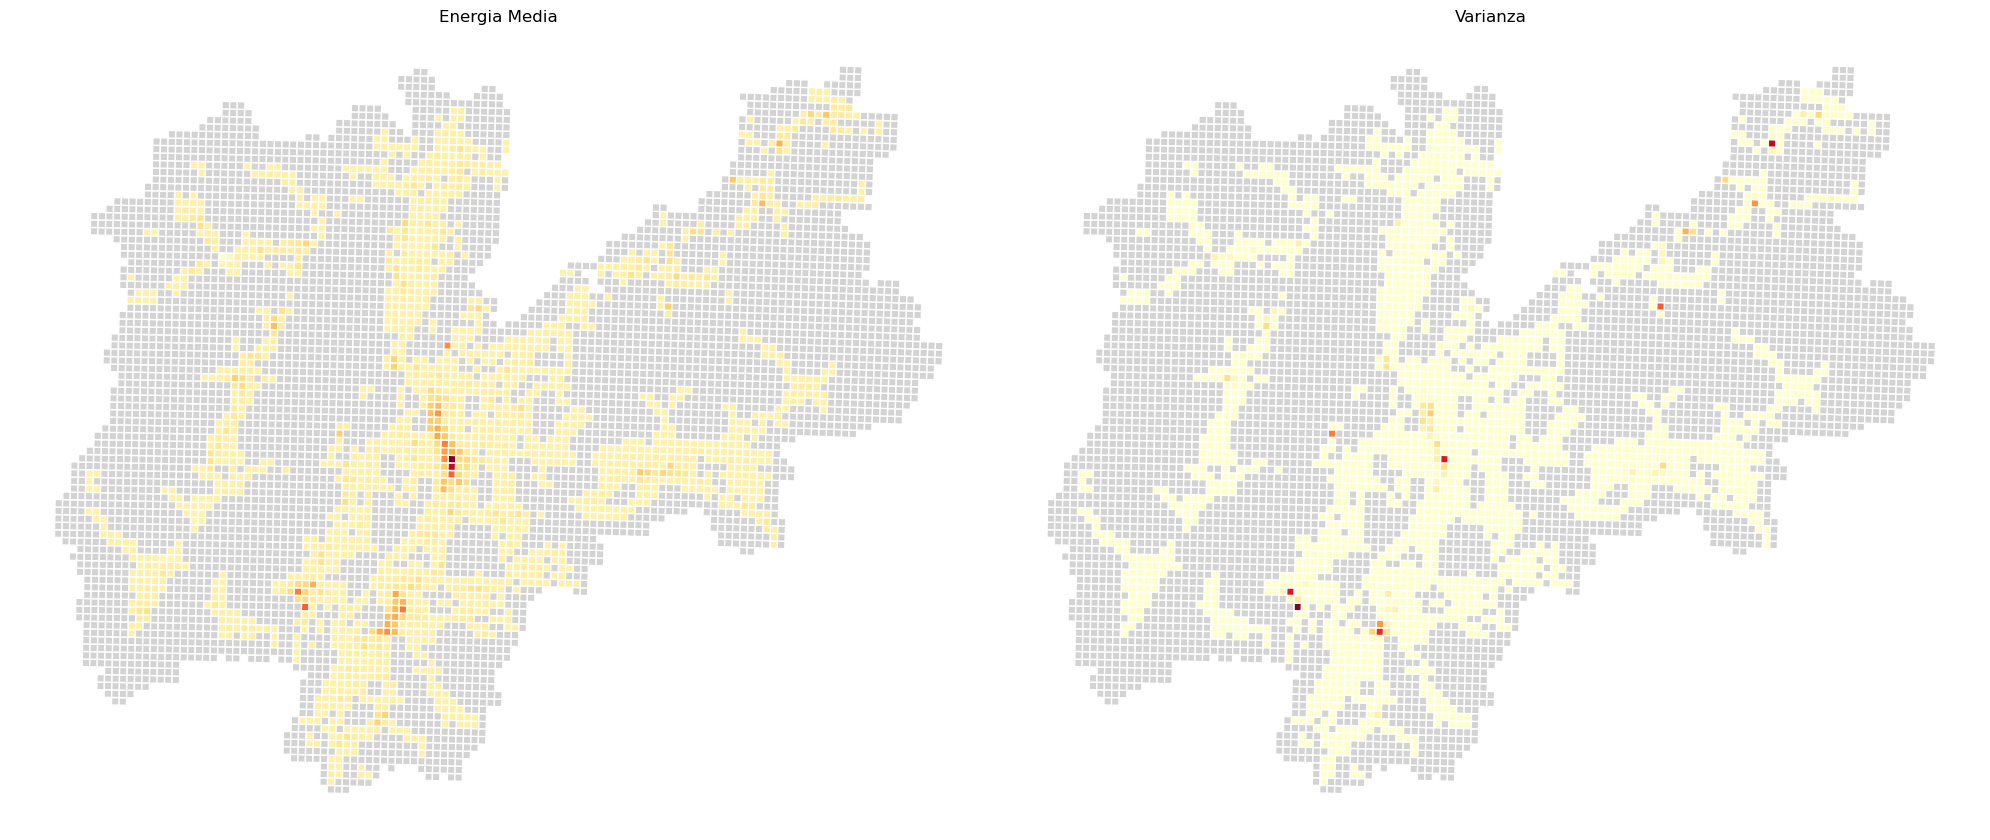

In [679]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

media_e_var_gdf.plot(
    ax=axs[0],
    column='mean_energy',
    cmap='YlOrRd',
    legend=False,
    edgecolor='white',
    missing_kwds={'color': 'lightgrey', 'label': '0 ubicazioni'}
)
axs[0].set_title("Energia Media")
axs[0].axis('off')

media_e_var_gdf.plot(
    ax=axs[1],
    column='var_energy',
    cmap='YlOrRd',
    legend=False,
    edgecolor='white',
    missing_kwds={'color': 'lightgrey', 'label': 'Nessuna linea'}
)
axs[1].set_title("Varianza")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Le aree a più alto consumo medio di energia si concentrano principalmente nei pressi di Trento, Rovereto, Arco e Pergine Valsugana. Si osserva inoltre che queste stesse zone presentano anche una varianza elevata nei consumi. Questo comportamento può essere spiegato dal fatto che le aree urbane ospitano numerosi edifici, attività commerciali e impianti industriali, i quali tendono a consumare molta energia durante il giorno, mentre di notte, essendo chiusi o inattivi, il consumo si riduce drasticamente.

Possiamo vedere che ci sono anche zone con energia media negativa.

In [684]:
def plot_meanvar (what):

    """
    Funzione che prende in ingresso 'mean_energy' o 'var_energy' e plotta un grafico
    rispettivamente del consumo medio o della sua varianza nei mesi di settembre e dicembre
    """

    
    _min = media_e_var_gdf[what].min()
    _max = media_e_var_gdf[what].max()

    n_colors = 256
    greens = plt.cm.Greens_r(np.linspace(0.3, 1, n_colors // 2))
    reds = plt.cm.Reds(np.linspace(0.3, 1, n_colors // 2))
    colors = np.vstack((greens, reds))
    #cmap = ListedColormap(colors)

    # Uso TwoSlopeNorm per dire al colormap dove si trova il "centro" (cioè lo 0)
    if what == 'mean_energy':
        norm = TwoSlopeNorm(vmin=_min, vcenter=0, vmax=_max)
        cmap = ListedColormap(colors)
        title = 'Energia media nei mesi di sett e dec'
    else:
        norm = norm = Normalize(vmin=_min, vmax=_max)
        cmap='YlOrRd'
        title = 'Varianza dell\'energia nei mesi di sett e dec'
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    media_e_var_gdf.plot(
        column=what,
        ax=ax,
        cmap=cmap,
        norm=norm,
        linewidth=0.1,
        edgecolor='gray',
        legend=True,
        vmin=_min,
        vmax=_max,
        missing_kwds={
            "color": "lightgrey",
            "label": "Nessun dato"
        }
    )
    ax.set_title(title)
    plt.show()

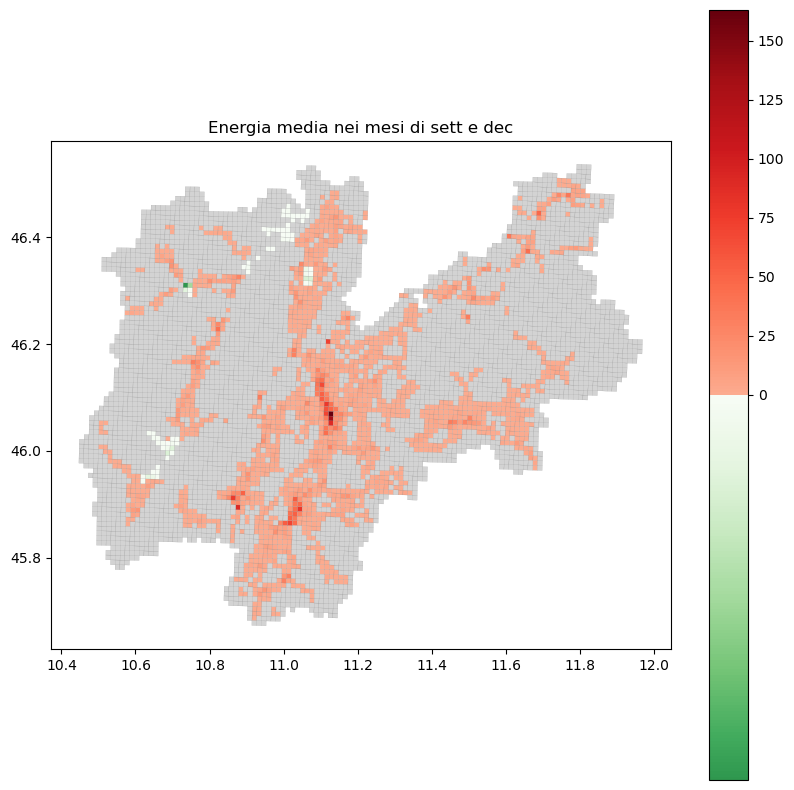

In [686]:
plot_meanvar('mean_energy')

Le zone colorate in verde sono quelle a energia media negativa. Facendo una brave ricerca si nota che queste zone corrispondono alle posizioni delle dighe idroelettriche di Cimego, Fontanedo, La Rocca, Fontanino, Santa Giustina e Dambel Pozzena.

## Territorio urbano di Trento

Per selezionare correttamente i confini del territorio urbano di Trento, abbiamo scaricato i file ufficiali del 2013 dell'ISTAT, al sito: https://www.istat.it/notizia/confini-delle-unita-amministrative-a-fini-statistici-al-1-gennaio-2018-2/. In questo modo abbiamo una mappatura accurata e ci permette di prevedere al meglio i valori dei consumi energetici.
NB! per leggere le coordinate abbiamo usato il file Com01012013_g_WGS84.shp, nella cartella Com01012013_g.
NB! e' stata usata la versione generalizzata del file

In [697]:
comuni_gdf = gpd.read_file(r"C:\Users\Francesco\Desktop\UniTN\datascience\progetto\Limiti01012013_g\Com01012013_g/Com01012013_g_WGS84.shp")

# Filtro il comune di Trento
trento_gdf = comuni_gdf[comuni_gdf['COMUNE'] == 'Trento'] 

# Assicuro che i due GeoDataFrame abbiano lo stesso sistema di coordinate
gdfs['grid'] = gdfs['grid'].to_crs(trento_gdf.crs)

# Trovo le celle che corrispondono al comune
celle_trento = gpd.sjoin(gdfs['grid'], trento_gdf, predicate='intersects')

# Salvo in gdfs
gdfs['trento_urbano'] = celle_trento

Faccio il plot per vedere se funziona

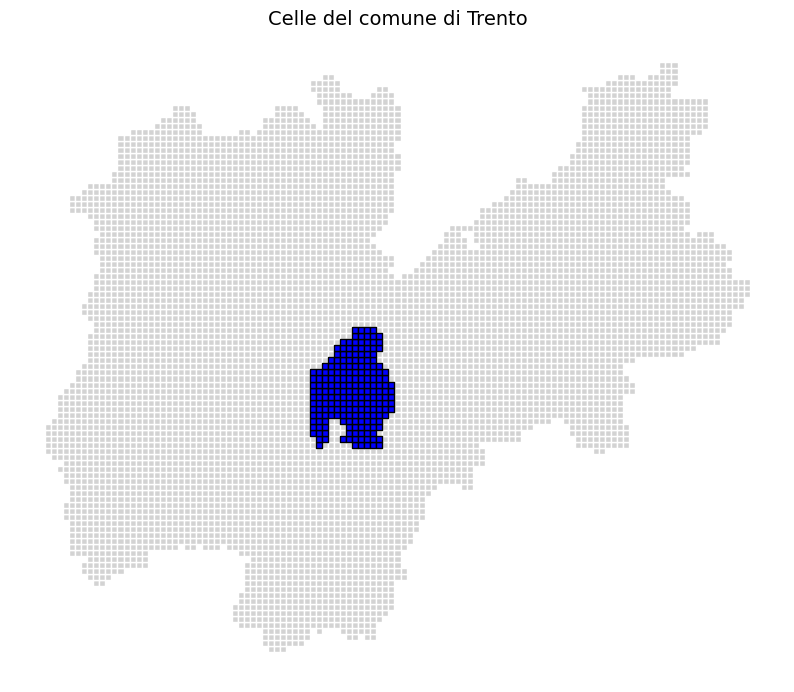

In [700]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot mappa base
gdfs['grid'].plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot celle zona urbana Trento
gdfs['trento_urbano'].plot(ax=ax, color='blue', edgecolor='black')

ax.set_title("Celle del comune di Trento", fontsize=14)
ax.axis('off')

plt.show()

In [702]:
gdfs['trento_urbano'].shape

(200, 13)

In [704]:
df_train

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,SET,DEC,LU,MA,ME,GI,VE,SA,DO
0,155,1,1,4,0.072206,9.3,18.9,15.384091,0,0.0,1,0,0,0,0,0,1,0,0
1,155,1,0,4,0.129090,11.9,12.9,12.315000,0,0.0,1,0,0,0,0,0,1,0,0
2,155,2,1,4,0.128870,12.3,15.9,13.897727,0,0.4,1,0,0,0,0,0,0,1,0
3,155,2,0,4,0.131733,12.2,13.1,12.550000,0,0.0,1,0,0,0,0,0,0,1,0
4,155,3,1,4,0.102435,12.2,19.2,15.213636,0,1.0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241885,11099,29,0,3,0.325564,-2.6,0.0,-1.485000,0,0.4,0,1,0,0,0,0,0,0,1
241886,11099,30,1,3,0.324854,-7.3,-1.4,-4.270455,0,0.0,0,1,1,0,0,0,0,0,0
241887,11099,30,0,3,0.336806,-7.7,-6.1,-6.905000,0,0.0,0,1,1,0,0,0,0,0,0
241888,11099,31,1,3,0.337902,-9.9,-2.4,-5.723256,0,0.0,0,1,0,1,0,0,0,0,0


## Dataframe finale per il training

Ora creo il df finale che usero' per il training. Per farlo copio df_train e metto una colonna target che indica i valori energetici alla stessa fascia ma del giorno dopo

In [708]:
trentino_dataset_reg = df_train.copy()

# Mi basta shiftare tutto di 2 posizioni dato che ho il df ordinato per mesi, giorni, fasce
trentino_dataset_reg['TargetReg'] = trentino_dataset_reg['energy'].copy().shift(-2)
trentino_dataset_reg = trentino_dataset_reg.dropna(subset=['TargetReg']).reset_index(drop=True)

# Elimino le righe del 31 dicembre che hanno dati fasati, ovvero i dati energetici del 1 novembre della cella successiva,
# per come ho creato il dataframe
trentino_dataset_reg = trentino_dataset_reg[(trentino_dataset_reg['DEC'] != 1) | (trentino_dataset_reg['day'] != 31)]

In [709]:
trentino_dataset_reg

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,SET,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg
0,155,1,1,4,0.072206,9.3,18.9,15.384091,0,0.0,1,0,0,0,0,0,1,0,0,0.128870
1,155,1,0,4,0.129090,11.9,12.9,12.315000,0,0.0,1,0,0,0,0,0,1,0,0,0.131733
2,155,2,1,4,0.128870,12.3,15.9,13.897727,0,0.4,1,0,0,0,0,0,0,1,0,0.102435
3,155,2,0,4,0.131733,12.2,13.1,12.550000,0,0.0,1,0,0,0,0,0,0,1,0,0.118528
4,155,3,1,4,0.102435,12.2,19.2,15.213636,0,1.0,1,0,0,0,0,0,0,0,1,0.178414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241883,11099,28,0,3,0.319740,-1.8,-0.6,-1.015789,0,0.2,0,1,0,0,0,0,0,1,0,0.325564
241884,11099,29,1,3,0.331215,-0.3,2.2,0.713953,0,1.2,0,1,0,0,0,0,0,0,1,0.324854
241885,11099,29,0,3,0.325564,-2.6,0.0,-1.485000,0,0.4,0,1,0,0,0,0,0,0,1,0.336806
241886,11099,30,1,3,0.324854,-7.3,-1.4,-4.270455,0,0.0,0,1,1,0,0,0,0,0,0,0.337902


Ora prendo solo le celle della zona urbana di Trento per farmi il df che usero' per la classificazione

In [713]:
trento_cell_ids = gdfs['trento_urbano']['cellId']

# Filtro trentino_dataset_reg per tenere solo i cellId della zona urbana di Trento
trentino_dataset_class = trentino_dataset_reg[trentino_dataset_reg['cellId'].isin(trento_cell_ids)].copy()

In [714]:
trentino_dataset_class

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,SET,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg
68076,4030,1,1,10,0.343408,11.9,17.5,15.665909,0,0.0,1,0,0,0,0,0,1,0,0,0.355429
68077,4030,1,0,10,0.381553,13.1,14.9,13.850000,0,0.0,1,0,0,0,0,0,1,0,0,0.389464
68078,4030,2,1,10,0.355429,11.0,16.0,13.836364,0,0.6,1,0,0,0,0,0,0,1,0,0.321361
68079,4030,2,0,10,0.389464,10.6,12.5,11.780000,0,0.0,1,0,0,0,0,0,0,1,0,0.390838
68080,4030,3,1,10,0.321361,13.9,18.8,15.772727,0,1.2,1,0,0,0,0,0,0,0,1,0.514038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152247,6256,28,0,6,0.130148,3.2,4.0,3.495000,0,0.4,0,1,0,0,0,0,0,1,0,0.126187
152248,6256,29,1,6,0.115692,3.1,4.6,3.843182,0,0.0,0,1,0,0,0,0,0,0,1,0.108612
152249,6256,29,0,6,0.126187,2.0,3.4,2.610000,0,0.0,0,1,0,0,0,0,0,0,1,0.133091
152250,6256,30,1,6,0.108612,0.5,7.2,2.909091,0,0.0,0,1,1,0,0,0,0,0,0,0.110783


Ora devo capire quando classificare un energia come alta o bassa. Per farlo la cosa piu' semplice e' calcolare la media dell'energia, e usare quella come soglia

In [718]:
trentino_dataset_class['TargetReg'].mean()

12.86867353370626

Decidiamo quindi di usare 22 come soglia per classificare una cella come ad alta energia. Mi creo quindi la colonna target che assumeraà valore 1 se l'energia media di quel mese, giorno, fascia oraria supera 22, 0 altrimenti.
Creo quindi una colonna target per la classificazione, che mi indica se la cella e' o meno ad alta energia il giorno successivo

In [720]:
trentino_dataset_class['TargetClas'] = (trentino_dataset_class['TargetReg'] >= 22 ).astype(int)

In [721]:
trentino_dataset_class

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,...,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg,TargetClas
68076,4030,1,1,10,0.343408,11.9,17.5,15.665909,0,0.0,...,0,0,0,0,0,1,0,0,0.355429,0
68077,4030,1,0,10,0.381553,13.1,14.9,13.850000,0,0.0,...,0,0,0,0,0,1,0,0,0.389464,0
68078,4030,2,1,10,0.355429,11.0,16.0,13.836364,0,0.6,...,0,0,0,0,0,0,1,0,0.321361,0
68079,4030,2,0,10,0.389464,10.6,12.5,11.780000,0,0.0,...,0,0,0,0,0,0,1,0,0.390838,0
68080,4030,3,1,10,0.321361,13.9,18.8,15.772727,0,1.2,...,0,0,0,0,0,0,0,1,0.514038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152247,6256,28,0,6,0.130148,3.2,4.0,3.495000,0,0.4,...,1,0,0,0,0,0,1,0,0.126187,0
152248,6256,29,1,6,0.115692,3.1,4.6,3.843182,0,0.0,...,1,0,0,0,0,0,0,1,0.108612,0
152249,6256,29,0,6,0.126187,2.0,3.4,2.610000,0,0.0,...,1,0,0,0,0,0,0,1,0.133091,0
152250,6256,30,1,6,0.108612,0.5,7.2,2.909091,0,0.0,...,1,1,0,0,0,0,0,0,0.110783,0


Ora ho i dataframe finali da poter usare: trentino_dataset_reg per la regressione a tutta la provincia, e trentino_dataset_class per la classificazione delle celle della zona urbana di Trento.
Procedo dunque a salvare i dataframes.

In [725]:
trentino_dataset_reg.to_csv("trentino_dataset_reg.csv", index=False)
trentino_dataset_class.to_csv("trentino_dataset_class.csv", index=False)